In [ ]:
!git clone https://github.com/fulifeng/Temporal_Relational_Stock_Ranking.git

Cloning into 'Temporal_Relational_Stock_Ranking'...
remote: Enumerating objects: 9134, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9134 (delta 0), reused 6 (delta 0), pack-reused 9126 (from 1)
Receiving objects: 100% (9134/9134), 330.32 MiB | 9.40 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (11378/11378), done.


In [ ]:
!tar zxvf /content/Temporal_Relational_Stock_Ranking/data/relation.tar.gz

relation/
relation/sector_industry/
relation/sector_industry/NASDAQ_industry_ticker.json
relation/sector_industry/NYSE_industry_ticker.json
relation/sector_industry/NASDAQ_industry_relation.npy
relation/sector_industry/NYSE_industry_relation.npy
relation/wikidata/
relation/wikidata/NASDAQ_wiki_relation.npy
relation/wikidata/NYSE_wiki_relation.npy
relation/wikidata/NYSE_connections.json
relation/wikidata/NASDAQ_connections.json
relation/wikidata/selected_wiki_connections.csv


In [ ]:
import gdown

# Shared file ID from the URL
file_id = '1fyNCZ62pEItTQYEBzLwsZ9ehX_-Ai3qT'

# Construct the download URL
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Download the file
gdown.download(url,quiet=False)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1fyNCZ62pEItTQYEBzLwsZ9ehX_-Ai3qT
From (redirected): https://drive.google.com/uc?export=download&id=1fyNCZ62pEItTQYEBzLwsZ9ehX_-Ai3qT&confirm=t&uuid=58900df2-f8fb-439a-88d7-11b9f698ebe3
To: /content/pretrain.tar.gz
100%|██████████| 570M/570M [00:12<00:00, 44.2MB/s]


'pretrain.tar.gz'

In [ ]:
!tar zxvf /content/Temporal_Relational_Stock_Ranking/data/pretrain.tar.gz

pretrain/
pretrain/NASDAQ_rank_lstm_seq-16_unit-64_2.csv.npy
pretrain/NYSE_rank_lstm_seq-8_unit-32_0.csv.npy


In [ ]:
import os

folder_path = '//content//Temporal_Relational_Stock_Ranking//data//2013-01-01'  # change to your target folder

for filename in os.listdir(folder_path):
    for x in ['NASDAQ','NYSEAMERICAN']:
      if filename.startswith(x):
          file_path = os.path.join(folder_path, filename)
          if os.path.isfile(file_path):
              os.remove(file_path)


In [ ]:
%cd /content/Temporal_Relational_Stock_Ranking/training

/content/Temporal_Relational_Stock_Ranking/training


In [11]:
%%writefile relation_rank_lstm.py
import argparse
import copy
import numpy as np
import os
import random
import tensorflow as tf
from time import time
from tensorflow.keras import layers, models, optimizers, losses, initializers # TF 2.x imports

# Assuming these utility files are compatible or updated for TF 2.x / NumPy usage
from load_data import load_EOD_data, load_relation_data
from evaluator import evaluate

# Set seeds for reproducibility (TF 2.x style)
seed = 123456789
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# --- Keras Model Definition ---
class RelationalRanker(models.Model):
    def __init__(self, parameters, inner_prod=False, flat=False, name='RelationalRanker', **kwargs):
        super().__init__(name=name, **kwargs)
        self.p = parameters
        self.inner_prod = inner_prod
        self.flat = flat
        self.unit = self.p['unit']

        # Define layers
        self.rel_weight_dense = layers.Dense(1, activation=tf.nn.leaky_relu, name='rel_weight_dense')

        if not self.inner_prod:
            self.head_weight_dense = layers.Dense(1, activation=tf.nn.leaky_relu, name='head_weight_dense')
            self.tail_weight_dense = layers.Dense(1, activation=tf.nn.leaky_relu, name='tail_weight_dense')

        if self.flat:
            self.flat_dense = layers.Dense(
                self.unit, activation=tf.nn.leaky_relu,
                kernel_initializer=initializers.GlorotUniform(), # TF 2.x initializer
                name='flat_dense'
            )

        self.prediction_dense = layers.Dense(
            1, activation=tf.nn.leaky_relu, name='reg_fc',
            kernel_initializer=initializers.GlorotUniform() # TF 2.x initializer
        )

    def call(self, inputs, training=None):
        # inputs should be a dictionary: {'feature': ..., 'base_price': ..., 'relation': ..., 'rel_mask': ...}
        feature = inputs['feature']      # Shape: (batch_size, unit)
        base_price = inputs['base_price']  # Shape: (batch_size, 1)
        relation = inputs['relation']    # Shape: (batch_size, batch_size, rel_dim) - Assuming batch_size = num_tickers
        rel_mask = inputs['rel_mask']    # Shape: (batch_size, batch_size)

        batch_size = tf.shape(feature)[0]
        all_one = tf.ones([batch_size, 1], dtype=tf.float32)

        # Relation processing
        rel_weight = self.rel_weight_dense(relation) # Shape: (batch_size, batch_size, 1)

        # Calculate relational attention weights
        if self.inner_prod:
            # print('inner product weight') # Use tf.print for TF 2.x graph mode
            inner_weight = tf.matmul(feature, feature, transpose_b=True) # Shape: (batch_size, batch_size)
            weight = tf.multiply(inner_weight, rel_weight[:, :, -1])     # Shape: (batch_size, batch_size)
        else:
            # print('sum weight') # Use tf.print
            head_weight = self.head_weight_dense(feature) # Shape: (batch_size, 1)
            tail_weight = self.tail_weight_dense(feature) # Shape: (batch_size, 1)
            weight = tf.add(
                tf.add(
                    tf.matmul(head_weight, all_one, transpose_b=True), # Shape: (batch_size, batch_size)
                    tf.matmul(all_one, tail_weight, transpose_b=True)  # Shape: (batch_size, batch_size)
                ), rel_weight[:, :, -1] # Shape: (batch_size, batch_size)
            )

        # Apply mask and softmax for attention
        weight_masked = tf.nn.softmax(tf.add(rel_mask, weight), axis=0) # Use axis=0 for softmax over stocks

        # Propagate features
        outputs_proped = tf.matmul(weight_masked, feature) # Shape: (batch_size, unit)

        # Concatenate and optional flat layer
        if self.flat:
            # print('one more hidden layer') # Use tf.print
            outputs_concated_input = tf.concat([feature, outputs_proped], axis=1) # Shape: (batch_size, 2 * unit)
            outputs_concated = self.flat_dense(outputs_concated_input)          # Shape: (batch_size, unit)
        else:
            outputs_concated = tf.concat([feature, outputs_proped], axis=1) # Shape: (batch_size, 2 * unit)

        # Final prediction layer
        # Note: The original concatenated [feature, outputs_proped] before the optional flat layer.
        # If flat=True, the input to prediction_dense should be outputs_concated (size unit).
        # If flat=False, the input should be outputs_concated (size 2*unit).
        # Let's adjust the prediction layer input based on the 'flat' flag logic.
        # However, the original code *always* feeds outputs_concated (either original concat or after flat dense)
        # into the final prediction layer. Let's keep that structure.
        prediction = self.prediction_dense(outputs_concated) # Shape: (batch_size, 1)

        # Calculate return ratio
        # Adding a small epsilon to prevent division by zero if base_price is 0
        epsilon = 1e-8
        return_ratio = tf.divide(tf.subtract(prediction, base_price), base_price + epsilon) # Shape: (batch_size, 1)

        return prediction, return_ratio

# --- Main Training Class ---
class ReRaLSTM_TF2:
    def __init__(self, data_path, market_name, tickers_fname, relation_name,
                 emb_fname, parameters, steps=1, epochs=50, batch_size=None, flat=False, gpu=False, in_pro=False):

        # Seeds already set globally
        self.data_path = data_path
        self.market_name = market_name
        self.tickers_fname = tickers_fname
        self.relation_name = relation_name
        self.parameters = copy.copy(parameters)
        self.steps = steps
        self.epochs = epochs
        self.flat = flat
        self.inner_prod = in_pro
        self.gpu = gpu # GPU usage is typically handled more automatically in TF2, but flag can be kept

        # Load data (Assuming NumPy arrays are returned)
        self.tickers = np.genfromtxt(os.path.join(data_path, '..', tickers_fname),
                                     dtype=str, delimiter='\t', skip_header=False)
        print('#tickers selected:', len(self.tickers))
        self.eod_data, self.mask_data, self.gt_data, self.price_data = \
            load_EOD_data(data_path, market_name, self.tickers, steps)

        # Relation data
        rname_tail = {'sector_industry': '_industry_relation.npy',
                      'wikidata': '_wiki_relation.npy'}
        rel_path = os.path.join(self.data_path, '..', 'relation', self.relation_name,
                                self.market_name + rname_tail[self.relation_name])
        self.rel_encoding, self.rel_mask = load_relation_data(rel_path)
        # Convert relations to TensorFlow constants ONCE
        self.tf_rel_encoding = tf.constant(self.rel_encoding, dtype=tf.float32)
        self.tf_rel_mask = tf.constant(self.rel_mask, dtype=tf.float32)
        print('relation encoding shape:', self.tf_rel_encoding.shape)
        print('relation mask shape:', self.tf_rel_mask.shape)

        # Embedding
        self.embedding = np.load(
            os.path.join(self.data_path, '..', 'pretrain', emb_fname))
        print('embedding shape:', self.embedding.shape)

        # Batch size
        if batch_size is None:
            # Full batch training - batch size is the number of tickers
            self.batch_size = len(self.tickers)
        else:
            # Mini-batch training not directly supported by the original structure
            # which assumes processing all tickers simultaneously for relational part.
            # Sticking to full batch based on original logic.
             print("Warning: Original code implies full batch training (batch_size = num_tickers). Ignoring provided batch_size argument.")
             self.batch_size = len(self.tickers)
             if self.batch_size != len(self.tickers):
                 raise ValueError("batch_size must equal the number of tickers for this model structure.")


        # Data split indices
        self.valid_index = 756
        self.test_index = 1008
        self.trade_dates = self.mask_data.shape[1]
        # self.fea_dim = 5 # Not directly used in TF2 model definition if embeddings are inputs

        # Instantiate Model and Optimizer
        self.model = RelationalRanker(self.parameters, inner_prod=self.inner_prod, flat=self.flat)
        self.optimizer = optimizers.Adam(learning_rate=self.parameters['lr'])
        self.mse_loss_fn = losses.MeanSquaredError() # Use Keras MSE


    def get_batch(self, offset):
        # This function remains largely the same as it prepares NumPy arrays
        seq_len = self.parameters['seq']
        # Ensure indices are within bounds
        max_offset = self.embedding.shape[1] - seq_len - self.steps
        if offset > max_offset:
             print(f"Warning: offset {offset} exceeds max allowed {max_offset}. Clamping.")
             offset = max_offset

        mask_batch = self.mask_data[:, offset: offset + seq_len + self.steps]
        mask_batch = np.min(mask_batch, axis=1) # Mask if inactive at *any* point in window

        return self.embedding[:, offset, :], \
               np.expand_dims(mask_batch, axis=1), \
               np.expand_dims(self.price_data[:, offset + seq_len - 1], axis=1), \
               np.expand_dims(self.gt_data[:, offset + seq_len + self.steps - 1], axis=1)

    # --- Rank Loss Calculation ---
    @tf.function # Compile for performance
    def _calculate_rank_loss(self, return_ratio, ground_truth, mask):
        """Calculates the pairwise ranking loss."""
        # Ensure inputs are tensors
        return_ratio = tf.convert_to_tensor(return_ratio, dtype=tf.float32)
        ground_truth = tf.convert_to_tensor(ground_truth, dtype=tf.float32)
        mask = tf.convert_to_tensor(mask, dtype=tf.float32)

        batch_size = tf.shape(return_ratio)[0]
        all_one = tf.ones([batch_size, 1], dtype=tf.float32)

        # Pairwise differences
        pre_pw_dif = tf.subtract(
            tf.matmul(return_ratio, all_one, transpose_b=True),
            tf.matmul(all_one, return_ratio, transpose_b=True)
        )
        gt_pw_dif = tf.subtract(
            tf.matmul(all_one, ground_truth, transpose_b=True), # Note the order swap from original for consistency
            tf.matmul(ground_truth, all_one, transpose_b=True)  # gt_j - gt_i
        )
        # Original gt_pw_dif was gt_j - gt_i. Let's match that.
        # pre_pw_dif is pre_i - pre_j
        # Loss wants pre_i > pre_j when gt_i > gt_j (sign(pre) == sign(gt))
        # Penalize when sign(pre) != sign(gt), which means pre * gt < 0
        # The original loss used relu( pre * gt * mask_pw ) -> this penalized when pre * gt > 0 ?
        # Let's re-read the original loss: relu( pre_pw_dif * gt_pw_dif * mask_pw )
        # pre_pw_dif = pred_i - pred_j
        # gt_pw_dif = gt_j - gt_i = -(gt_i - gt_j)
        # Loss = relu( (pred_i - pred_j) * (gt_j - gt_i) * mask_ij )
        #      = relu( -(pred_i - pred_j) * (gt_i - gt_j) * mask_ij )
        # This means it penalizes when (pred_i - pred_j) and (gt_i - gt_j) have *opposite* signs.
        # This *is* the correct ranking loss formulation (hinge loss).

        mask_pw = tf.matmul(mask, mask, transpose_b=True) # Pairwise mask

        rank_loss = tf.reduce_mean(
            tf.nn.relu(
                tf.multiply(pre_pw_dif, gt_pw_dif) * mask_pw # Multiply element-wise
            )
        )
        return rank_loss

    # --- Training Step ---
    @tf.function # Compile for performance
    def _train_step(self, feature, base_price, ground_truth, mask):
        """Performs one training step."""
        with tf.GradientTape() as tape:
            # Forward pass
            inputs = {
                'feature': feature, 'base_price': base_price,
                'relation': self.tf_rel_encoding, 'rel_mask': self.tf_rel_mask
            }
            prediction, return_ratio = self.model(inputs, training=True)

            # Calculate losses
            reg_loss = self.mse_loss_fn(ground_truth, return_ratio, sample_weight=mask)
            rank_loss = self._calculate_rank_loss(return_ratio, ground_truth, mask)
            total_loss = reg_loss + tf.cast(self.parameters['alpha'], tf.float32) * rank_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        # Apply gradients
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        return reg_loss, rank_loss, total_loss

    # --- Test Step ---
    @tf.function # Compile for performance
    def _test_step(self, feature, base_price, ground_truth, mask):
        """Performs one evaluation step."""
        # Forward pass
        inputs = {
            'feature': feature, 'base_price': base_price,
            'relation': self.tf_rel_encoding, 'rel_mask': self.tf_rel_mask
        }
        prediction, return_ratio = self.model(inputs, training=False) # Set training=False

        # Calculate losses
        reg_loss = self.mse_loss_fn(ground_truth, return_ratio, sample_weight=mask)
        rank_loss = self._calculate_rank_loss(return_ratio, ground_truth, mask)
        total_loss = reg_loss + tf.cast(self.parameters['alpha'], tf.float32) * rank_loss

        return reg_loss, rank_loss, total_loss, return_ratio # Return predictions for evaluation

    def train(self):
        """Main training and evaluation loop."""

        # Prepare arrays for storing best results (NumPy arrays)
        best_valid_pred = np.zeros([len(self.tickers), self.test_index - self.valid_index], dtype=float)
        best_valid_gt = np.zeros_like(best_valid_pred)
        best_valid_mask = np.zeros_like(best_valid_pred)
        best_test_pred = np.zeros([len(self.tickers), self.trade_dates - self.test_index], dtype=float)
        best_test_gt = np.zeros_like(best_test_pred)
        best_test_mask = np.zeros_like(best_test_pred)

        best_valid_perf = {'mse': np.inf, 'mrrt': 0.0, 'btl': 0.0}
        best_test_perf = {'mse': np.inf, 'mrrt': 0.0, 'btl': 0.0}
        best_valid_loss = np.inf # Track best average validation loss per step

        # Define checkpoint path
        checkpoint_dir = './tf_ckpts'
        checkpoint_path = os.path.join(checkpoint_dir, 'best_model.weights.h5') # Keras H5 format
        os.makedirs(checkpoint_dir, exist_ok=True)


        # Calculate number of steps per phase once
        num_train_steps = self.valid_index - self.parameters['seq'] - self.steps + 1
        num_valid_steps = self.test_index - self.valid_index
        num_test_steps = self.trade_dates - self.test_index # Adjusting test range slightly

        if num_train_steps <= 0 or num_valid_steps <= 0 or num_test_steps <= 0:
             raise ValueError("Invalid data split indices or sequence length/steps.")


        # --- Epoch Loop ---
        batch_offsets = np.arange(start=0, stop=self.valid_index - self.parameters['seq'] - self.steps + 1, dtype=int)

        for i in range(self.epochs):
            t1 = time()
            np.random.shuffle(batch_offsets)

            # --- Training Phase ---
            epoch_tra_loss, epoch_tra_reg_loss, epoch_tra_rank_loss = 0.0, 0.0, 0.0
            for j, offset in enumerate(batch_offsets):
                emb_batch, mask_batch, price_batch, gt_batch = self.get_batch(offset)

                # Convert data to Tensors for the step function
                feature_tf = tf.convert_to_tensor(emb_batch, dtype=tf.float32)
                base_price_tf = tf.convert_to_tensor(price_batch, dtype=tf.float32)
                ground_truth_tf = tf.convert_to_tensor(gt_batch, dtype=tf.float32)
                mask_tf = tf.convert_to_tensor(mask_batch, dtype=tf.float32)

                # Run training step
                step_reg_loss, step_rank_loss, step_total_loss = self._train_step(
                    feature_tf, base_price_tf, ground_truth_tf, mask_tf
                )

                epoch_tra_reg_loss += step_reg_loss.numpy()
                epoch_tra_rank_loss += step_rank_loss.numpy()
                epoch_tra_loss += step_total_loss.numpy()

                # Optional: print progress within epoch
                # if (j + 1) % 100 == 0: print(f"Epoch {i+1}, Step {j+1}/{num_train_steps}")

            avg_tra_loss = epoch_tra_loss / num_train_steps
            avg_tra_reg_loss = epoch_tra_reg_loss / num_train_steps
            avg_tra_rank_loss = epoch_tra_rank_loss / num_train_steps
            print(f'Epoch {i+1} Train Loss: {avg_tra_loss:.6f} (Reg: {avg_tra_reg_loss:.6f}, Rank: {avg_tra_rank_loss:.6f})')


            # --- Validation Phase ---
            epoch_val_loss, epoch_val_reg_loss, epoch_val_rank_loss = 0.0, 0.0, 0.0
            # Temporary storage for current epoch's validation results
            cur_valid_pred_epoch = np.zeros_like(best_valid_pred)
            cur_valid_gt_epoch = np.zeros_like(best_valid_gt)
            cur_valid_mask_epoch = np.zeros_like(best_valid_mask)

            val_start_offset = self.valid_index - self.parameters['seq'] - self.steps + 1
            for j in range(num_valid_steps):
                cur_offset = val_start_offset + j
                emb_batch, mask_batch, price_batch, gt_batch = self.get_batch(cur_offset)

                feature_tf = tf.convert_to_tensor(emb_batch, dtype=tf.float32)
                base_price_tf = tf.convert_to_tensor(price_batch, dtype=tf.float32)
                ground_truth_tf = tf.convert_to_tensor(gt_batch, dtype=tf.float32)
                mask_tf = tf.convert_to_tensor(mask_batch, dtype=tf.float32)

                step_reg_loss, step_rank_loss, step_total_loss, step_rr = self._test_step(
                    feature_tf, base_price_tf, ground_truth_tf, mask_tf
                )

                epoch_val_reg_loss += step_reg_loss.numpy()
                epoch_val_rank_loss += step_rank_loss.numpy()
                epoch_val_loss += step_total_loss.numpy()

                # Store results for this step
                cur_valid_pred_epoch[:, j] = step_rr.numpy()[:, 0]
                cur_valid_gt_epoch[:, j] = gt_batch[:, 0]
                cur_valid_mask_epoch[:, j] = mask_batch[:, 0]

            avg_val_loss = epoch_val_loss / num_valid_steps
            avg_val_reg_loss = epoch_val_reg_loss / num_valid_steps
            avg_val_rank_loss = epoch_val_rank_loss / num_valid_steps
            print(f'Epoch {i+1} Valid Loss: {avg_val_loss:.6f} (Reg: {avg_val_reg_loss:.6f}, Rank: {avg_val_rank_loss:.6f})')

            # Evaluate performance for the current epoch's validation predictions
            cur_valid_perf = evaluate(cur_valid_pred_epoch, cur_valid_gt_epoch, cur_valid_mask_epoch)
            print(f'\t Valid performance (Epoch {i+1}):', cur_valid_perf)


            # --- Testing Phase ---
            epoch_test_loss, epoch_test_reg_loss, epoch_test_rank_loss = 0.0, 0.0, 0.0
             # Adjust num_test_steps based on available data after test_index
            actual_num_test_steps = self.trade_dates - self.parameters['seq'] - self.steps + 1 - (self.test_index - self.parameters['seq'] - self.steps + 1)
            # print(f"Num test steps calculated: {actual_num_test_steps}")

            cur_test_pred_epoch = np.zeros([len(self.tickers), actual_num_test_steps], dtype=float)
            cur_test_gt_epoch = np.zeros_like(cur_test_pred_epoch)
            cur_test_mask_epoch = np.zeros_like(cur_test_pred_epoch)


            test_start_offset = self.test_index - self.parameters['seq'] - self.steps + 1
            for j in range(actual_num_test_steps): # Iterate for the correct number of steps
                 cur_offset = test_start_offset + j
                 # print(f"Test step {j}, offset {cur_offset}")
                 emb_batch, mask_batch, price_batch, gt_batch = self.get_batch(cur_offset)

                 feature_tf = tf.convert_to_tensor(emb_batch, dtype=tf.float32)
                 base_price_tf = tf.convert_to_tensor(price_batch, dtype=tf.float32)
                 ground_truth_tf = tf.convert_to_tensor(gt_batch, dtype=tf.float32)
                 mask_tf = tf.convert_to_tensor(mask_batch, dtype=tf.float32)

                 step_reg_loss, step_rank_loss, step_total_loss, step_rr = self._test_step(
                     feature_tf, base_price_tf, ground_truth_tf, mask_tf
                 )

                 epoch_test_reg_loss += step_reg_loss.numpy()
                 epoch_test_rank_loss += step_rank_loss.numpy()
                 epoch_test_loss += step_total_loss.numpy()

                 # Store results
                 cur_test_pred_epoch[:, j] = step_rr.numpy()[:, 0]
                 cur_test_gt_epoch[:, j] = gt_batch[:, 0]
                 cur_test_mask_epoch[:, j] = mask_batch[:, 0]

            # Avoid division by zero if actual_num_test_steps is 0
            if actual_num_test_steps > 0:
                 avg_test_loss = epoch_test_loss / actual_num_test_steps
                 avg_test_reg_loss = epoch_test_reg_loss / actual_num_test_steps
                 avg_test_rank_loss = epoch_test_rank_loss / actual_num_test_steps
                 print(f'Epoch {i+1} Test Loss: {avg_test_loss:.6f} (Reg: {avg_test_reg_loss:.6f}, Rank: {avg_test_rank_loss:.6f})')
                 cur_test_perf = evaluate(cur_test_pred_epoch, cur_test_gt_epoch, cur_test_mask_epoch)
                 print(f'\t Test performance (Epoch {i+1}):', cur_test_perf)
            else:
                 print(f'Epoch {i+1} Test Phase: Skipped (No test steps)')
                 cur_test_perf = {'mse': np.inf, 'mrrt': 0.0, 'btl': 0.0} # Default performance


            # --- Check for Best Validation Loss and Save ---
            if avg_val_loss < best_valid_loss:
                print(f'** Better validation loss found: {avg_val_loss:.6f} < {best_valid_loss:.6f}. Saving model and results. **')
                best_valid_loss = avg_val_loss
                # Save the model weights
                self.model.save_weights(checkpoint_path)
                # Store the corresponding performance and predictions/gt/masks
                best_valid_perf = copy.copy(cur_valid_perf)
                best_test_perf = copy.copy(cur_test_perf)
                # Adjust slicing for potentially different test set size
                best_valid_pred = copy.copy(cur_valid_pred_epoch)
                best_valid_gt = copy.copy(cur_valid_gt_epoch)
                best_valid_mask = copy.copy(cur_valid_mask_epoch)
                best_test_pred = copy.copy(cur_test_pred_epoch[:, :best_test_pred.shape[1]]) # Ensure size match
                best_test_gt = copy.copy(cur_test_gt_epoch[:, :best_test_gt.shape[1]])
                best_test_mask = copy.copy(cur_test_mask_epoch[:, :best_test_mask.shape[1]])


            t4 = time()
            print(f'Epoch {i+1} finished. Time: {t4 - t1:.4f} sec')
            print("-" * 30)


        # --- End of Training ---
        print('\n' + "=" * 50)
        print('Training finished.')
        print(f'Best Validation Loss: {best_valid_loss:.6f}')
        print('Best Validation performance:', best_valid_perf)
        print('\t Corresponding Test performance:', best_test_perf)
        print("=" * 50)

        # Optionally, load the best weights back into the model before returning,
        # although the best_* arrays already hold the predictions from that best epoch.
        # print(f"Loading best model weights from {checkpoint_path}")
        # self.model.load_weights(checkpoint_path)

        # Return the results associated with the best validation loss epoch
        # Adjust test shapes to match the originally defined sizes if needed, though returning actual results is better.
        final_test_len = self.trade_dates - self.parameters['seq'] - self.test_index - self.steps + 1
        return best_valid_pred, best_valid_gt, best_valid_mask, \
               best_test_pred[:, :final_test_len], best_test_gt[:, :final_test_len], best_test_mask[:, :final_test_len]


    def update_model(self, parameters):
        """Updates hyperparameters. Re-instantiation might be needed in TF2."""
        print("Warning: Updating parameters might require re-instantiating the model and optimizer in TF2.")
        for name, value in parameters.items():
            self.parameters[name] = value
        # Potentially re-create model and optimizer if parameters changed significantly
        # self.model = RelationalRanker(...)
        # self.optimizer = optimizers.Adam(...)
        return True


if __name__ == '__main__':
    desc = 'train a relational rank lstm model (TF2 version)'
    parser = argparse.ArgumentParser(description=desc)
    parser.add_argument('-p', help='path of EOD data', default='../data/2013-01-01')
    parser.add_argument('-m', help='market name', default='NASDAQ')
    parser.add_argument('-t', help='fname for selected tickers')
    parser.add_argument('-l', default=4, type=int, help='length of historical sequence for feature')
    parser.add_argument('-u', default=64, type=int, help='number of hidden units in lstm/embeddings')
    parser.add_argument('-s', default=1, type=int, help='steps to make prediction')
    parser.add_argument('-r', default=0.001, type=float, help='learning rate')
    parser.add_argument('-a', default=1.0, type=float, help='alpha, the weight of ranking loss') # Ensure float default
    parser.add_argument('-g', '--gpu', type=int, default=0, help='use gpu (TF2 manages GPU more automatically)')

    parser.add_argument('-e', '--emb_file', type=str,
                        default='NASDAQ_rank_lstm_seq-16_unit-64_2.csv.npy',
                        help='fname for pretrained sequential embedding')
    parser.add_argument('-rn', '--rel_name', type=str,
                        default='sector_industry',
                        help='relation type: sector_industry or wikidata')
    parser.add_argument('-ip', '--inner_prod', type=int, default=0, help="use inner product for relational weights (1=True, 0=False)")
    parser.add_argument('--flat', action='store_true', help="add extra dense layer after feature concatenation") # Use action='store_true'
    parser.add_argument('--epochs', type=int, default=50, help="Number of training epochs")

    args = parser.parse_args()

    if args.t is None:
        args.t = args.m + '_tickers_qualify_dr-0.98_min-5_smooth.csv'
    args.gpu = (args.gpu == 1) # Flag still useful for information
    args.inner_prod = (args.inner_prod == 1)

    # Check for GPU
    physical_devices = tf.config.list_physical_devices('GPU')
    if args.gpu and physical_devices:
        print(f"Using GPU: {physical_devices[0]}")
        # TF2 generally uses the GPU automatically if available and compatible.
        # Specific device placement can be done using tf.device('/gpu:0') context manager
        # around model instantiation or within tf.function if needed, but often not required.
    elif args.gpu and not physical_devices:
        print("GPU requested but not available/visible to TensorFlow. Using CPU.")
    else:
        print("Using CPU.")


    parameters = {'seq': args.l, 'unit': args.u, 'lr': args.r, 'alpha': args.a}
    print('arguments:', args)
    print('parameters:', parameters)

    # Instantiate the TF2 version of the class
    RR_LSTM_Trainer = ReRaLSTM_TF2(
        data_path=args.p,
        market_name=args.m,
        tickers_fname=args.t,
        relation_name=args.rel_name,
        emb_fname=args.emb_file,
        parameters=parameters,
        steps=args.s,
        epochs=args.epochs, # Use parsed epochs
        batch_size=None, # Stick to full batch
        gpu=args.gpu,
        in_pro=args.inner_prod,
        flat=args.flat # Pass flat flag
    )

    pred_all = RR_LSTM_Trainer.train()

    # pred_all contains the numpy arrays for best valid/test predictions, gt, mask
    # Add logic here to save or use these results if needed.
    print("Training complete. Best predictions stored in returned variable.")
    # Example: Save results
    np.savez("training_results.npz",
              valid_pred=pred_all[0], valid_gt=pred_all[1], valid_mask=pred_all[2],
              test_pred=pred_all[3], test_gt=pred_all[4], test_mask=pred_all[5])


Overwriting relation_rank_lstm.py


In [21]:
!python relation_rank_lstm.py -m NYSE -l 8 -u 32 -a 10 -e NYSE_rank_lstm_seq-8_unit-32_0.csv.npy -g 1 --epochs 8

2025-05-07 04:43:10.637638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746592990.660074   11365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746592990.668522   11365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 04:43:10.700607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
arguments: Namespace(p='../data/2013-01-0

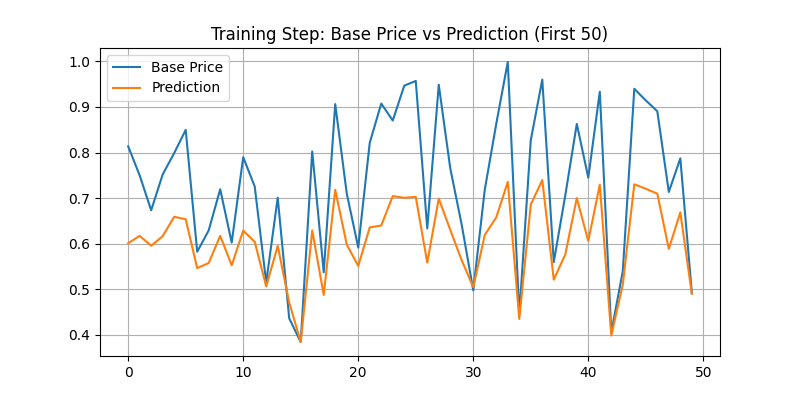

In [ ]:
!python relation_rank_lstm.py -m NYSE -l 8 -u 32 -a 10 -e NYSE_rank_lstm_seq-8_unit-32_0.csv.npy -g 1

2025-04-23 03:36:09.224808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745379369.244871    8134 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745379369.250924    8134 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 03:36:09.270946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Traceback (most recent call last):
  File "/content/Temporal_Relational_Stock_Ranking/training/relation_rank_lstm.py", line 6

In [ ]:
import numpy as np

# Load the NPZ file
data = np.load('/content/Temporal_Relational_Stock_Ranking/training/training_results.npz')

# Iterate through all arrays in the NPZ file and print their shapes and data types
for array_name in data.files:
    array = data[array_name]
    print(f"Array Name: {array_name}")
    print(f"Shape: {array.shape}")
    print(f"Data Type: {array.dtype}")
    print()  # Adding a blank line for readability


Array Name: valid_pred
Shape: (1737, 252)
Data Type: float64

Array Name: valid_gt
Shape: (1737, 252)
Data Type: float64

Array Name: valid_mask
Shape: (1737, 252)
Data Type: float64

Array Name: test_pred
Shape: (1737, 229)
Data Type: float64

Array Name: test_gt
Shape: (1737, 229)
Data Type: float64

Array Name: test_mask
Shape: (1737, 229)
Data Type: float64



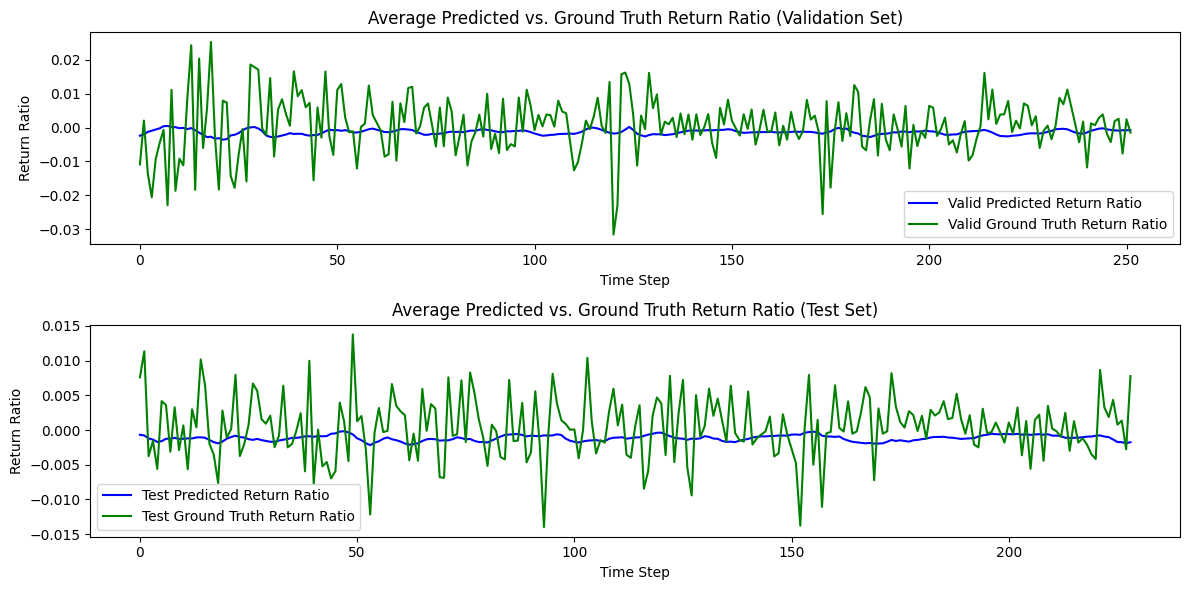

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Load the NPZ file
data = np.load('/content/Temporal_Relational_Stock_Ranking/training/training_results.npz')

# Get arrays from NPZ
valid_pred = data['valid_pred']
valid_gt = data['valid_gt']
valid_mask = data['valid_mask']
test_pred = data['test_pred']
test_gt = data['test_gt']
test_mask = data['test_mask']

# Mask the predictions and ground truth values (set to NaN where mask is 0)
valid_pred_masked = np.where(valid_mask > 0, valid_pred, np.nan)
valid_gt_masked = np.where(valid_mask > 0, valid_gt, np.nan)
test_pred_masked = np.where(test_mask > 0, test_pred, np.nan)
test_gt_masked = np.where(test_mask > 0, test_gt, np.nan)

# Plot the average predictions vs. ground truth for valid and test sets

# Calculate average values (ignore NaNs) for valid and test predictions and ground truth
avg_valid_pred = np.nanmean(valid_pred_masked, axis=0)
avg_valid_gt = np.nanmean(valid_gt_masked, axis=0)
avg_test_pred = np.nanmean(test_pred_masked, axis=0)
avg_test_gt = np.nanmean(test_gt_masked, axis=0)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot for valid set
plt.subplot(2, 1, 1)
plt.plot(avg_valid_pred, label="Valid Predicted Return Ratio", color='blue')
plt.plot(avg_valid_gt, label="Valid Ground Truth Return Ratio", color='green')
plt.title("Average Predicted vs. Ground Truth Return Ratio (Validation Set)")
plt.xlabel("Time Step")
plt.ylabel("Return Ratio")
plt.legend()

# Plot for test set
plt.subplot(2, 1, 2)
plt.plot(avg_test_pred, label="Test Predicted Return Ratio", color='blue')
plt.plot(avg_test_gt, label="Test Ground Truth Return Ratio", color='green')
plt.title("Average Predicted vs. Ground Truth Return Ratio (Test Set)")
plt.xlabel("Time Step")
plt.ylabel("Return Ratio")
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


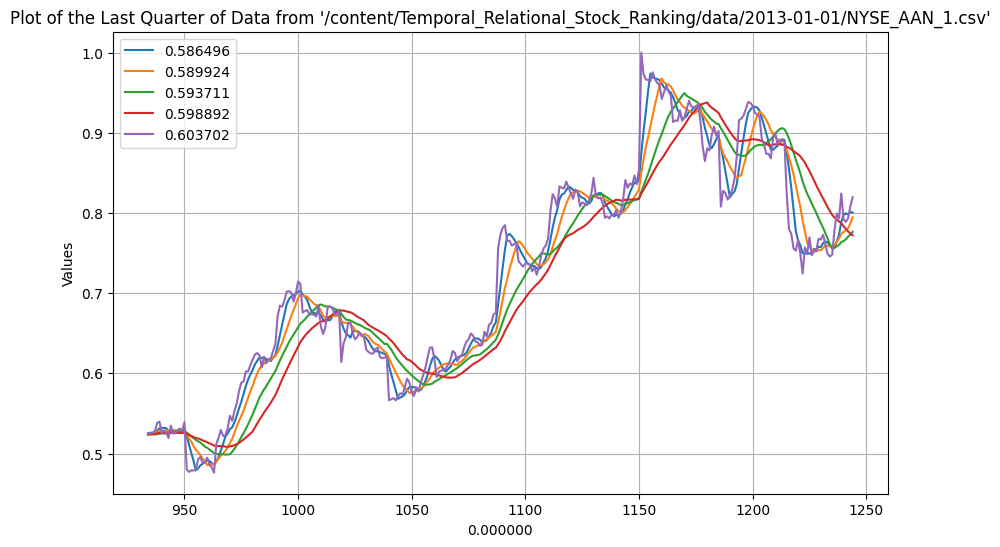

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_last_quarter(file_path):
    """
    Reads a CSV file, divides the data into four parts based on rows,
    uses the first column of the last part as the x-axis, and plots
    the remaining columns of the last part as separate lines.

    Args:
        file_path (str): The path to the CSV file.
    """
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            print(f"Error: The CSV file '{file_path}' is empty.")
            return

        num_rows = len(df)
        if num_rows < 4:
            print(f"Warning: The CSV file has fewer than 4 rows. Plotting all data.")
            start_index = 0
        else:
            start_index = num_rows // 4 * 3  # Calculate the starting index of the last quarter

        last_quarter_df = df.iloc[start_index:]

        if last_quarter_df.empty:
            print("Warning: The last quarter of the data is empty.")
            return

        x_column = last_quarter_df.columns[0]
        x_values = last_quarter_df[x_column]

        if pd.api.types.is_numeric_dtype(x_values):
            plt.figure(figsize=(10, 6))

            for column in last_quarter_df.columns[1:]:
                if pd.api.types.is_numeric_dtype(last_quarter_df[column]):
                    plt.plot(x_values, last_quarter_df[column], label=column)
                else:
                    print(f"Warning: Column '{column}' in the last quarter is not numeric and will be skipped.")

            plt.xlabel(x_column)
            plt.ylabel("Values")
            plt.title(f"Plot of the Last Quarter of Data from '{file_path}'")
            plt.legend()
            plt.grid(True)
            plt.show()

        else:
            print(f"Error: The first column '{x_column}' in the last quarter is not numeric and cannot be used as the x-axis.")

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    file_path = "/content/Temporal_Relational_Stock_Ranking/data/2013-01-01/NYSE_AAN_1.csv"
    plot_last_quarter(file_path)

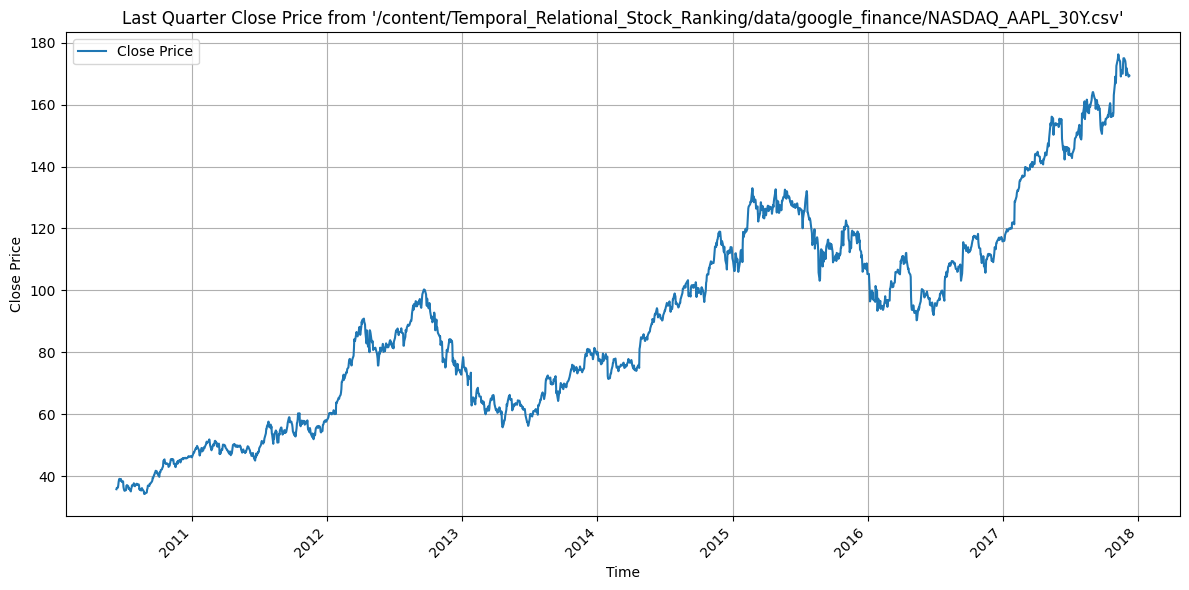

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_last_quarter_close_price(file_path):
    """
    Reads a CSV file with a datetime index, divides the data into four parts
    based on rows, and plots only the 'Close' price of the last part
    against the datetime index.

    Args:
        file_path (str): The path to the CSV file.
    """
    try:
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        if df.empty:
            print(f"Error: The CSV file '{file_path}' is empty.")
            return

        num_rows = len(df)
        if num_rows < 4:
            print(f"Warning: The CSV file has fewer than 4 rows. Plotting all data.")
            last_quarter_df = df
        else:
            start_index = num_rows // 4 * 3
            last_quarter_df = df.iloc[start_index:]

        if last_quarter_df.empty:
            print("Warning: The last quarter of the data is empty.")
            return

        plt.figure(figsize=(12, 6))

        if 'Close' in last_quarter_df.columns and pd.api.types.is_numeric_dtype(last_quarter_df['Close']):
            plt.plot(last_quarter_df.index, last_quarter_df['Close'], label='Close Price')
            plt.xlabel("Time")
            plt.ylabel("Close Price")
            plt.title(f"Last Quarter Close Price from '{file_path}'")
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        elif 'Close' not in last_quarter_df.columns:
            print("Error: 'Close' column not found in the CSV file.")
        else:
            print("Error: 'Close' column is not numeric and cannot be plotted.")

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    file_path = "/content/Temporal_Relational_Stock_Ranking/data/google_finance/NASDAQ_AAPL_30Y.csv"
    plot_last_quarter_close_price(file_path)